In [68]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import argparse
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc,brier_score_loss

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import dataframe_image as dfi

from Utils.loading import *
from Utils.treino import *
from Utils.init_redes import *
from Utils.KD import *
from Utils.ensemble import *
from Utils.redes import *
from Utils.data_set import *
from Utils.cobertura import *
from Utils.graficos import *

In [361]:
if torch.cuda.is_available():
    device = 'cuda'  
else:
    device = 'cpu'
print(device)

cuda


In [11]:
data_set = "Cifar100"

if data_set == "Cifar10":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes = cifar10()
elif data_set == "Cifar100":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader= cifar100()

Files already downloaded and verified
Files already downloaded and verified


# CARREGANDO AS REDES

In [350]:
n_redes = 3

models = load_cifar100(n_redes)

# SOFTMAX -> MEAN (SEM TEMPERATURA)

In [351]:
outputs = torch.tensor([]).to("cuda")
labels_cat = torch.tensor([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs_0 = caculate_outputs(models[0:n_redes],images.to("cuda"))
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs = torch.cat((outputs,outputs_0),dim=1)
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas


outputs_stack = torch.stack(tuple(outputs),dim=0)

outputs_softmax = torch.nn.functional.softmax(outputs_stack, dim=-1)
outputs_mean = torch.mean(outputs_softmax, dim=0)

uncs, _, _, predict = calculate_predicted(outputs_mean)
acuracia_base = (1-calculate_correct(predict, labels_cat))*100
curvaRC_base = RC_curve(predict,labels_cat.to("cuda"),uncs)
AURC_base = AURC(predict, labels_cat.to("cuda"), uncs)
AUROC_base = AUROC(predict, labels_cat.to("cuda"), -uncs)

Acuracia: 78.63 AURC 0.0543269882735943 AUROC: 0.8809495328606743


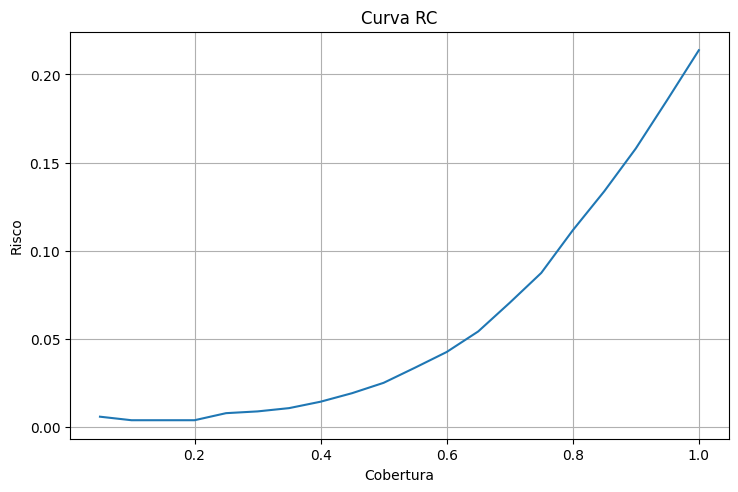

In [352]:
C = np.arange(0.05,1.05,0.05)

print("Acuracia:", acuracia_base, "AURC", AURC_base, "AUROC:", AUROC_base)

g1 = plot_graph(C,curvaRC_base, title="Curva RC", xlabel="Cobertura", ylabel="Risco")

g1.savefig("./Graficos/Temperatura/{}/{} Redes/CurvaRC.jpeg".format(data_set,n_redes))

plt.show()

# SOFTMAX -> MEAN

In [ ]:
# ENEMBLE T IGUAIS

correct_list = list()
covarege_list = list()
auc_list = list()
auroc_list = list()

outputs = torch.tensor([]).to("cuda")
labels_cat = torch.tensor([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs_0 = caculate_outputs(models[0:n_redes],images.to("cuda"))
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs = torch.cat((outputs,outputs_0),dim=1)
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas

#valores = np.arange(0.01, 5.01, 0.01)
valores = np.arange(0.01, 2.001, 0.01)

for valor in valores:
    T = valor

    output0 = outputs[0]/T
    output1 = outputs[1]/T
    output2 = outputs[2]/T
    outputs_stack = torch.stack((output0,output1,output2),dim=0)

    outputs_softmax = torch.nn.functional.softmax(outputs_stack, dim=-1)
    outputs_mean = torch.mean(outputs_softmax, dim=0)
    
    uncs, _, _, predict = calculate_predicted(outputs_mean)
    correct_list.append((1-calculate_correct(predict, labels_cat))*100)
    covarege_list.append(RC_curve(predict,labels_cat.to("cuda"),uncs))
    auc_list.append(AURC(predict, labels_cat.to("cuda"), uncs))
    auroc_list.append(AUROC(predict, labels_cat.to("cuda"), -uncs))
    
    
    
# ENEMBLE T DIFERENTES

correct_list_Tdif = list()
covarege_list_Tdif = list()
auc_list_Tdif = list()
auroc_list_Tdif = list()


outputs2 = torch.tensor([]).to("cuda")

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs_0 = caculate_outputs(models[0:n_redes],images.to("cuda"))
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs2 = torch.cat((outputs2,outputs_0),dim=1)

valores1 = np.arange(0.01, 2.001, 0.01)
valores2 = np.arange(0.01, 2.001, 0.01)
valores3 = np.arange(0.01, 2.001, 0.01)
i = 0

for valor1 in valores1:
    T1 = valor1
    output0 = outputs2[0]/T1
    print(i, end=" ")
    i += 1
    for valor2 in valores2:
        T2 = valor2
        output1 = outputs2[1]/T2
        for valor3 in valores3:
            T3 = valor3
            output2 = outputs2[2]/T3
            outputs_stack2 = torch.stack((output0,output1,output2),dim=0)
        
        

            

            outputs_softmax2 = torch.nn.functional.softmax(outputs_stack2, dim=-1)
            outputs_mean2 = torch.mean(outputs_softmax2, dim=0)

            uncs, _, _, predict = calculate_predicted(outputs_mean2)

            correct_list_Tdif.append(calculate_correct(predict, labels_cat))
            covarege_list_Tdif.append(RC_curve(predict,labels_cat.to("cuda"),uncs))
            auc_list_Tdif.append(AURC(predict, labels_cat.to("cuda"), uncs))
            auroc_list_Tdif.append(AUROC(predict, labels_cat.to("cuda"), -uncs))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

COMEÇOU AS 21:19

In [ ]:
valoresXX = np.arange(0.01, 2.001, 0.01)
valorXX = []
for i in valoresXX:
    valorXX.append(i)
    
min_indexes = np.argmin(covarege_list, axis=0)
min_values = np.min(covarege_list, axis=0)
for element in min_indexes:
    print(valorXX[element], end=" ")

In [ ]:
T = np.arange(0.01, 2.001, 0.01)
C = np.arange(0.05,1.05,0.05)

g1 = plot_graph(T,correct_list, title="Acuracia", ylabel="Acuracia", xlabel="Temperatura")

#g2 = plot_graph(C,min_values, title="Incerteza", ylabel="Risco", xlabel="Cobertura")
#g2 = plot_mutiple_graph(C,[min_values,curvaRC_base], 2,title="Incerteza", ylabel="Risco", xlabel="Cobertura", label="Min_values, Base", multi_label=True)
g2 = plot_mutiple_graph(C,[min_values,curvaRC_base, covarege_list[np.argmin(auc_list, axis=0)]], 3,
                        title="Incerteza", ylabel="Risco", xlabel="Cobertura", label="Min_values, Base, Melhor", multi_label=True)

g3 = plot_graph(T,auc_list, title="AURC", ylabel="AURC", xlabel="Temperatura")

g4 = plot_graph(T,auroc_list, title="AUROC", ylabel="AUROC", xlabel="Temperatura")

g1.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/Acuracia.jpeg".format(data_set, n_redes))
g2.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/Curva_RC.jpeg" .format(data_set, n_redes))
g3.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/AUC.jpeg"     .format(data_set, n_redes))
g4.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/AUROC.jpeg"   .format(data_set, n_redes))

plt.show()

t = T[auc_list.index(min(auc_list))]
acuracia11 = correct_list[auc_list.index(min(auc_list))]
auroc11 = auroc_list_Tdif[auc_list_Tdif.index(min(auc_list_Tdif))]
print("Valor de T: ", t, "Acuracia:", acuracia11, "Ponto minimo do AURC", min(auc_list), "Ponto minimo do AUROC:", auroc11)

In [ ]:
valor11=list()
valor12=list()
valor13=list()

for i in T:
    for j in T:
        for k in T:
            valor11.append(i)
            valor12.append(j)
            valor13.append(k)

min_indexes1 = np.argmin(covarege_list_Tdif, axis=0)
min_values1 = np.min(covarege_list_Tdif, axis=0)
for element in min_indexes1:
    print(round(valor11[element],2), end=" ")
print()
for element in min_indexes1:
    print(round(valor12[element],2), end=" ")
for element in min_indexes1:
    print(round(valor13[element],2), end=" ")

In [ ]:
X, Y = np.meshgrid(T, T)

fig1 = plt.figure()
fig1.set_size_inches(8.5, 8.5)
ax1 = fig1.add_subplot()
fig1.subplots_adjust(top=0.85)
ax1.set_title("Acuracia")
ax1.set_xlabel("T")
ax1.set_ylabel("T")
pos1 = ax1.get_position()

index = 0
Correct = list()
for i in range(T.shape[0]):
    aux = list()
    for j in range(T.shape[0]):
        aux.append((1-correct_list_Tdif[index])*100)
        index += 1
    Correct.append(aux)

ax1 = ax1.contourf(X, Y, Correct, levels=50)
ax1.changed()
cbar1 = plt.colorbar(ax1)

plt.grid()
plt.show()

#g2 = plot_graph(C,min_values1, title="Incerteza", ylabel="Risco", xlabel="Cobertura")
#fig2 = plot_mutiple_graph(C,[min_values1,curvaRC_base], 2,title="Incerteza", ylabel="Risco", xlabel="Cobertura", label="Min_values, Base", multi_label=True)
fig2 = plot_mutiple_graph(C,[min_values1,curvaRC_base, covarege_list_Tdif[np.argmin(auc_list_Tdif, axis=0)]], 3,
                        title="Incerteza", ylabel="Risco", xlabel="Cobertura", label="Min_values, Base, Melhor", multi_label=True)
fig3 = plt.figure()
fig3.set_size_inches(8.5, 8.5)
ax3 = fig3.add_subplot()
fig3.subplots_adjust(top=0.85)
ax3.set_title("AUC")
ax3.set_xlabel("T")
ax3.set_ylabel("T")
pos3 = ax3.get_position()

index = 0
auc = list()
for i in range(T.shape[0]):
    aux = list()
    for j in range(T.shape[0]):
        aux.append(auc_list_Tdif[index])
        index += 1
    auc.append(aux)

ax3 = ax3.contourf(X, Y, auc, levels=50)
ax3.changed()
cbar3 = plt.colorbar(ax3)

plt.grid()
plt.show()

fig4 = plt.figure()
fig4.set_size_inches(8.5, 8.5)
ax4 = fig4.add_subplot()
fig4.subplots_adjust(top=0.85)
ax4.set_title("AUROC")
ax4.set_xlabel("T")
ax4.set_ylabel("T")
pos4 = ax4.get_position()

index = 0
auroc = list()
for i in range(T.shape[0]):
    aux = list()
    for j in range(T.shape[0]):
        aux.append(auroc_list_Tdif[index])
        index += 1
    auroc.append(aux)

ax4 = ax4.contourf(X, Y, auroc, levels=50)
ax4.changed()
cbar4 = plt.colorbar(ax4)

plt.grid()
plt.show()

#fig1.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/Acuracia_Tdifs.jpeg".format(data_set, n_redes))
fig2.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/Curva_RC_Tdif.jpeg" .format(data_set, n_redes))
#fig3.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/AUC_Tdifs.jpeg"     .format(data_set, n_redes))
#fig4.savefig("./Graficos/Temperatura/{}/{} Redes/Softmean/AUROC_Tdifs.jpeg"   .format(data_set, n_redes))

valor11=list()
valor12=list()
valor13=list()

for i in T:
    for j in T:
        for k in T:
            valor11.append(i)
            valor12.append(j)
            valor13.append(k)
        
t11 = valor11[auc_list_Tdif.index(min(auc_list_Tdif))]
t12 = valor12[auc_list_Tdif.index(min(auc_list_Tdif))]
t13 = valor13[auc_list_Tdif.index(min(auc_list_Tdif))]

acuracia12 = (1-correct_list_Tdif[auc_list_Tdif.index(min(auc_list_Tdif))])*100
auroc12 = auroc_list_Tdif[auc_list_Tdif.index(min(auc_list_Tdif))]
print("Valor de T1: ", t11, "Valor de T2: ", t12,"Valor de T3: ", t13,"Acuracia:", acuracia12, "Ponto minimo do AURC", min(auc_list_Tdif), "Ponto minimo do AUROC:", auroc12)

# MEAN -> SOFTMAX

In [ ]:
# ENEMBLE T IGUAIS

correct_list2 = list()
covarege_list2 = list()
auc_list2 = list()
auroc_list2 = list()

outputs = torch.tensor([]).to("cuda")
labels_cat = torch.tensor([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs_0 = caculate_outputs(models[0:n_redes],images.to("cuda"))
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs = torch.cat((outputs,outputs_0),dim=1)
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas

valores = np.arange(0.01, 2.001, 0.01)
valores = np.arange(0.01, 2.001, 0.01)

for valor in valores:
    T = valor

    output0 = outputs[0]/T
    output1 = outputs[1]/T
    output2 = outputs[2]/T
    outputs_stack = torch.stack((output0,output1,output2),dim=0)

    outputs_mean = torch.mean(outputs_stack, dim=0)
    outputs_softmax = torch.nn.functional.softmax(outputs_mean, dim=-1)
    
    uncs, _, _, predict = calculate_predicted(outputs_softmax)
    correct_list2.append((1-calculate_correct(predict, labels_cat))*100)
    covarege_list2.append(RC_curve(predict,labels_cat.to("cuda"),uncs))
    auc_list2.append(AURC(predict, labels_cat.to("cuda"), uncs))
    auroc_list2.append(AUROC(predict, labels_cat.to("cuda"), -uncs))
    
    
    
# ENEMBLE T DIFERENTES

correct_list_Tdif2 = list()
covarege_list_Tdif2 = list()
auc_list_Tdif2 = list()
auroc_list_Tdif2 = list()


outputs2 = torch.tensor([]).to("cuda")

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs_0 = caculate_outputs(models[0:n_redes],images.to("cuda"))
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs2 = torch.cat((outputs2,outputs_0),dim=1)

valores1 = np.arange(0.01, 2.001, 0.01)
valores2 = np.arange(0.01, 2.001, 0.01)
i = 0

for valor1 in valores1:
    T1 = valor1
    output0 = outputs2[0]/T1
    print(i, end=" ")
    i += 1
    for valor2 in valores2:
        T2 = valor2
        output1 = outputs2[1]/T2
        for valor3 in valores3:
            T3 = valor3
            output2 = outputs2[2]/T3
            outputs_stack2 = torch.stack((output0,output1,output2),dim=0)

            outputs_mean2 = torch.mean(outputs_stack2, dim=0)
            outputs_softmax2 = torch.nn.functional.softmax(outputs_mean2, dim=-1)

            uncs, _, _, predict = calculate_predicted(outputs_softmax2)

            correct_list_Tdif2.append(calculate_correct(predict, labels_cat))
            covarege_list_Tdif2.append(RC_curve(predict,labels_cat.to("cuda"),uncs))
            auc_list_Tdif2.append(AURC(predict, labels_cat.to("cuda"), uncs))
            auroc_list_Tdif2.append(AUROC(predict, labels_cat.to("cuda"), -uncs))

0 1 2 3 4 5 6 

In [ ]:
min_indexes2 = np.argmin(covarege_list2, axis=0)
min_values2 = np.min(covarege_list2, axis=0)
for element in min_indexes2:
    print(valorXX[element], end=" ")

In [ ]:
T = np.arange(0.01, 2.001, 0.01)
C = np.arange(0.05,1.05,0.05)

g1 = plot_graph(T,correct_list2, title="Acuracia", ylabel="Acuracia", xlabel="Temperatura")

#g2 = plot_graph(C,min_values2, title="Incerteza", ylabel="Risco", xlabel="Cobertura")
#g2 = plot_mutiple_graph(C,[min_values2,curvaRC_base], 2,title="Incerteza", ylabel="Risco", xlabel="Cobertura", label="Min_values, Base", multi_label=True)
g2 = plot_mutiple_graph(C,[min_values2,curvaRC_base, covarege_list2[np.argmin(auc_list2, axis=0)]], 3,
                        title="Incerteza", ylabel="Risco", xlabel="Cobertura", label="Min_values, Base, Melhor", multi_label=True)

g3 = plot_graph(T,auc_list2, title="AURC", ylabel="AURC", xlabel="Temperatura")

g4 = plot_graph(T,auroc_list2, title="AUROC", ylabel="AUROC", xlabel="Temperatura")

g1.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/Acuracia.jpeg".format(data_set, n_redes))
g2.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/Curva_RC.jpeg" .format(data_set, n_redes))
g3.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/AUC.jpeg"     .format(data_set, n_redes))
g4.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/AUROC.jpeg"   .format(data_set, n_redes))
plt.show()

t = T[auc_list2.index(min(auc_list2))]
acuracia21 = correct_list2[auc_list2.index(min(auc_list2))]
auroc21 = auroc_list2[auc_list2.index(min(auc_list2))]
print("Valor de T: ", t, "Acuracia:", acuracia21, "Ponto minimo do AURC", min(auc_list2), "Ponto minimo do AUROC:", auroc21)

In [ ]:
min_indexes22 = np.argmin(covarege_list_Tdif2, axis=0)
min_values22 = np.min(covarege_list_Tdif2, axis=0)
for element in min_indexes22:
    print(round(valor12[element],2), end=" ")
print()
for element in min_indexes22:
    print(round(valor12[element],2), end=" ")
for element in min_indexes22:
    print(round(valor13[element],2), end=" ")

In [ ]:
X, Y = np.meshgrid(T, T)

fig1 = plt.figure()
fig1.set_size_inches(8.5, 8.5)
ax1 = fig1.add_subplot()
fig1.subplots_adjust(top=0.85)
ax1.set_title("Acuracia")
ax1.set_xlabel("T")
ax1.set_ylabel("T")
pos1 = ax1.get_position()

index = 0
Correct2 = list()
for i in range(T.shape[0]):
    aux = list()
    for j in range(T.shape[0]):
        aux.append((1-correct_list_Tdif2[index])*100)
        index += 1
    Correct2.append(aux)

ax1 = ax1.contourf(X, Y, Correct2, levels=50)
ax1.changed()
cbar1 = plt.colorbar(ax1)

plt.grid()
plt.show()

#g2 = plot_graph(C,min_values22, title="Incerteza", ylabel="Risco", xlabel="Cobertura")
fig2 = plot_mutiple_graph(C,[min_values22,curvaRC_base, covarege_list_Tdif2[np.argmin(auc_list_Tdif2, axis=0)]], 3,
                        title="Incerteza", ylabel="Risco", xlabel="Cobertura", label="Min_values, Base, Melhor", multi_label=True)

fig3 = plt.figure()
fig3.set_size_inches(8.5, 8.5)
ax3 = fig3.add_subplot()
fig3.subplots_adjust(top=0.85)
ax3.set_title("AUC")
ax3.set_xlabel("T")
ax3.set_ylabel("T")
pos3 = ax3.get_position()

index = 0
auc2 = list()
for i in range(T.shape[0]):
    aux = list()
    for j in range(T.shape[0]):
        aux.append(auc_list_Tdif2[index])
        index += 1
    auc2.append(aux)

ax3 = ax3.contourf(X, Y, auc2, levels=50)
ax3.changed()
cbar3 = plt.colorbar(ax3)

plt.grid()
plt.show()

fig4 = plt.figure()
fig4.set_size_inches(8.5, 8.5)
ax4 = fig4.add_subplot()
fig4.subplots_adjust(top=0.85)
ax4.set_title("AUROC")
ax4.set_xlabel("T")
ax4.set_ylabel("T")
pos4 = ax4.get_position()

index = 0
auroc2 = list()
for i in range(T.shape[0]):
    aux = list()
    for j in range(T.shape[0]):
        aux.append(auroc_list_Tdif2[index])
        index += 1
    auroc2.append(aux)

ax4 = ax4.contourf(X, Y, auroc2, levels=50)
ax4.changed()
cbar4 = plt.colorbar(ax4)

plt.grid()
plt.show()

#fig1.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/Acuracia_Tdifs.jpeg".format(data_set, n_redes))
fig2.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/Curva_RC_Tdif.jpeg" .format(data_set, n_redes))
#fig3.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/AUC_Tdifs.jpeg"     .format(data_set, n_redes))
#fig4.savefig("./Graficos/Temperatura/{}/{} Redes/Meansoft/AUROC_Tdifs.jpeg"   .format(data_set, n_redes))

valor12=list()
valor12=list()
valor13=list()

for i in T:
    for j in T:
        for k in T:
            valor12.append(i)
            valor12.append(j)
            valor13.append(k)
        
t11 = valor11[auc_list_Tdif2.index(min(auc_list_Tdif2))]
t12 = valor12[auc_list_Tdif2.index(min(auc_list_Tdif2))]
t13 = valor13[auc_list_Tdif2.index(min(auc_list_Tdif2))]
acuracia22 = (1-correct_list_Tdif2[auc_list_Tdif2.index(min(auc_list_Tdif2))])*100
auroc22 = auroc_list_Tdif2[auc_list_Tdif2.index(min(auc_list_Tdif2))]
print("Valor de T1: ", t12, "Valor de T2: ", t12, "Valor de T3: ", t13, "Acuracia:", acuracia22, "Ponto minimo do AURC", min(auc_list_Tdif2), "Ponto minimo do AUROC:", auroc22)

In [ ]:
acuracia2 = (1-min(correct_list_Tdif2))*100
teste = np.argmin(correct_list_Tdif2)
t11 = valor11[teste]
t12 = valor12[teste]
t13 = valor13[teste]
auc = auc_list_Tdif2[teste]
print(t12, t12, t13,acuracia2, auc)

# RESULTADOS FINAIS

In [ ]:
df = pd.DataFrame({'Tipo'    : ['Normal'             , 'Softmean'   , 'Softmean Tdif'   , 'Meansoft'    , 'Meansoft Tdif'],
                   'Acuracia': [acuracia_base        , acuracia11   , acuracia12        , acuracia21    , acuracia22],
                   'AURC'    : [round(AURC_base,5)   , min(auc_list), min(auc_list_Tdif), min(auc_list2), min(auc_list_Tdif2)],
                   'AUROC'   : [round(AUROC_base,5)  , auroc11      , auroc12           , auroc21       , auroc22]})

# Add a gradient based on values
df_img = df.style.background_gradient() 

# Save DataFrame as Image
dfi.export(df_img,"./Graficos/Temperatura/Cifar100/{} Redes/tabela.jpeg".format(n_redes),table_conversion='matplotlib')